In [83]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, stats
import matplotlib.pyplot as plt

## Select the source files 

#### Below are the files source containing the raw data for all 9 indicators:

In [2]:
df_pb = '10-PB - anual.xlsx' # Price to Book 
df_roa = '1-ROA - anual.xlsx' # roa > 0 then 1, else 0
#roa_t > roa_t-1 then 1, else 0
df_cfo = '2-CaixaeOp_v2.xlsx' # cf > 0 then 1, else 0
df_accrual = '3-Accrual.xlsx' # accrual_inverted > 0 then 1, else 0
df_liquidity = '5-Liquidez Corrente - anual.xlsx' # liq diff > 0 then 1, else 0
df_debt = '6-Endividamento - anual.xlsx' # debt diff > 0 then 0, else 1 *inverted*
df_stock_issue = '7-Qtde_Acoes - anual.xlsx' # issue diff != 0 then 0, else 1 *inverted*
df_margin = '8-Margem_Bruta - anual.xlsx' # margin diff > 0 then 1, else 0 
df_turnover = '9-Giro_Ativo - anual.xlsx' # turnover diff > 0 then 1, else 0
pb = pd.read_excel(df_pb, index_col='Date')

## Build the functions

#### The below functions aims to:
1) clean the raw data from the excel files; <br>
2) build the binary results (zero or one) for each indicador; and <br>
3) to transform the numpy array into a Data Frame.

In [3]:
def clean_data(data):
    '''
    clean excel files to work with only
    float and not strings
    data: it is the DataFrame from the Excel file
    '''
    
    df = pd.read_excel(data, index_col='Date')
    df = df.replace('-','')
    #df = df.convert_objects(convert_numeric=True)
    df = df.drop('conso',1)
    df = df.apply(pd.to_numeric) # convert all columns of DataFrame

    global label_columns2
    global label_index2
    label_columns2 = df.columns
    label_index2 = df.index
    # checar se tem alguma coluna que nao seja float:
    #g = x.columns.to_series().groupby(x.dtypes).groups
    #g
    return df

In [4]:
def array_to_df(data):
    '''
    transform np.array into DataFrame and label
    the columns and the index correctly
    data: it is the DataFrame from the Excel file
    '''
    df = pd.DataFrame(data, index=range(data.shape[0]),
                          columns=range(data.shape[1]))
    df.columns = label_columns2
    df.index = label_index2
    return df

In [5]:
def condition_cal(data, tipo, inverted=False):
    '''
    tipo means what the kind of condition. For example,
    Piotroski works with 2 types of condition: greater than zero
    or the actual value is greater the the previous value.
    data: it is the DataFrame from the Excel file
    tipo: Here the user must choose between :
          tipo == 'diff' which means greater than previou value or
          tipo == 'greater' which means greater than zero
    inverted: two indicators has inverted logic, if greater than zero
    then receives 0 otherwise receives 1. The standard is False. When
    working with inverted logic please insert "True".
    '''
    if tipo == 'diff':
        if inverted==True:
            condition = np.where(data.diff() < 0, 1, 0)
        elif inverted==False:
            condition = np.where(data.diff() > 0, 1, 0)
            
    elif tipo == 'greater':
        condition = np.where(data > 0, 1, 0)

    elif tipo == 'eq_offer':
        condition = np.where(data.diff() > 0, 0, 1)
        
    return condition

In [6]:
class Output(object):
    def __init__(self, returns_df, date_freq='A'):
        self.returns_df = returns_df if isinstance(
                returns_df, pd.DataFrame) else pd.DataFrame(returns_df)
        self.wealthpaths = self.returns_df.apply(self._calc_wealthpath)
        self._date_freq = str(date_freq).upper()
        if self._date_freq == 'D':
            self._freq = 252
        elif self._date_freq == 'M':
            self._freq = 12
        elif self._date_freq == 'A':
            self._freq = 1

    def _calc_annualized_return(self, series):
        avg_daily_return = series.mean()
        ann_return = avg_daily_return * self._freq
        return ann_return

    def _calc_annualized_std_dev(self, series):
        series_std = series.std()
        ann_std = series_std * (np.sqrt(self._freq))
        return ann_std

    def _calc_sharpe(self, ann_returns, ann_stds):
        sharpe = ann_returns.divide(ann_stds)
        return sharpe

    def _calc_hwm(self, wealthpath):
        hwm = wealthpath.expanding().max()
        return hwm

    def _calc_wealthpath(self, series):
        if series.iloc[0] != 0:
            first_dt = series.index[0]
            set_dt = first_dt - dt.timedelta(days=1)
            series.loc[set_dt] = 0.0
            series = series.sort_index()

        cum_prod = (1.0 + series).cumprod()
        return cum_prod

    def _calc_drawdowns(self, wealthpath):
        hwm = self._calc_hwm(wealthpath)
        drawdowns = wealthpath.divide(hwm).subtract(1.0)
        return drawdowns

    def _calc_lake_ratios(self, hwm, wps):
        lakes = hwm.subtract(wps)
        mountains = hwm.subtract(lakes)
        lake_ratios = lakes.sum() / mountains.sum()
        return lake_ratios

    def _calc_gain_to_pain_ratio(self, series):
        total_return_series = (1.0 + series).cumprod().subtract(1.0)
        total_return = total_return_series.iloc[-1]

        loss_returns_series = self.__get_loss_returns(series).abs()
        if not loss_returns_series.empty:
            total_loss_return_series = (1.0 + loss_returns_series).cumprod().subtract(1.0)
            total_loss_return = total_loss_return_series.iloc[-1]

            gpr = total_return / total_loss_return
        else:
            gpr = np.nan
        return gpr

    def __get_win_returns(self, series):
        win_returns = series[series >= 0.0]
        return win_returns

    def __get_loss_returns(self, series):
        loss_returns = series[series < 0.0]
        return loss_returns

    def _calc_win_rate(self, series):
        win_returns = self.__get_win_returns(series)
        rate = float(len(win_returns)) / float(len(series))
        return rate

    def _calc_loss_rate(self, series):
        loss_returns = self.__get_loss_returns(series)
        rate = float(len(loss_returns)) / float(len(series))
        return rate

    def _calc_avg_win_return(self, series):
        win_returns = self.__get_win_returns(series)
        avg = win_returns.mean()
        return avg

    def _calc_avg_loss_return(self, series):
        loss_returns = self.__get_loss_returns(series)
        avg = loss_returns.mean()
        return avg

    def _calc_winloss_ratio(self, series):
        wins = self.__get_win_returns(series)
        losses = self.__get_loss_returns(series)
        if len(losses) == 0.0:
            wl_ratio = np.nan
        else:
            wl_ratio = len(wins) / len(losses)
        return wl_ratio

    def _calc_expectancy(self, win_rates, avg_win, loss_rates, avg_loss):
        w_win = win_rates.multiply(avg_win)
        w_loss = loss_rates.multiply(avg_loss)
        exp = w_win.subtract(w_loss)
        return exp

    def generate_output(self):
        hwms = self.wealthpaths.apply(self._calc_hwm)
        lake_ratios = self._calc_lake_ratios(hwms, self.wealthpaths)
        lake_ratios.name = "Lake Ratio"

        drawdowns = self.wealthpaths.apply(self._calc_drawdowns)
        max_dds = drawdowns.min()
        max_dds.name = "Max Drawdown"

        ann_returns = self.returns_df.apply(self._calc_annualized_return)
        ann_returns.name = "Annualized Return"

        ann_stds = self.returns_df.apply(self._calc_annualized_std_dev)
        ann_stds.name = "Annualized Std Dev"

        sharpes = self._calc_sharpe(ann_returns, ann_stds)
        sharpes.name = "Sharpe Ratio"

        win_rates = self.returns_df.apply(self._calc_win_rate)
        win_rates.name = "Win Rate"

        loss_rates = self.returns_df.apply(self._calc_loss_rate)
        loss_rates.name = "Loss Rate"

        avg_win_returns = self.returns_df.apply(self._calc_avg_win_return)
        avg_win_returns.name = "Avg Win Return"

        avg_loss_returns = self.returns_df.apply(self._calc_avg_loss_return)
        avg_loss_returns.name = "Avg Loss Return"

        win_loss_ratio = self.returns_df.apply(self._calc_winloss_ratio)
        win_loss_ratio.name = "Win Loss Ratio"

        expectancy = self._calc_expectancy(win_rates, avg_win_returns,
                                           loss_rates, avg_loss_returns)
        expectancy.name = "Trade Expectancy"

        gpr = self.returns_df.apply(self._calc_gain_to_pain_ratio)
        gpr.name = 'Gain to Pain Ratio'

        output_df = pd.concat([lake_ratios, max_dds, ann_returns,
                               ann_stds, sharpes, win_rates,
                               loss_rates, avg_win_returns,
                               avg_loss_returns, expectancy,
                               gpr, ], axis=1).round(4)

        return output_df.T.sort_index()

In [7]:
def portfolio_returns(): 
    labels = ['2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31']
    piotroski = []
    momentum = []
    ibov = []
    for i in range(2004,2018):
        p = piotroski_return_switch(i, 6, 0, 'long', 3)
        m = piotroski_return_momentum_switch(i, 6, 0, 0, 'long', 3)
        i = ibov_return(close, i)
        piotroski.append(p)
        momentum.append(m)
        ibov.append(i)
        
    df = pd.DataFrame({'Ibovespa':ibov, 'Momentum':momentum, 'Piotroski':piotroski}, index=labels)
    df.index.name = 'Date'
    df.index = pd.to_datetime(labels)
    #df.index = pd.DatetimeIndex(df.index).year
    
    return df

In [8]:
def piotroski_rank(year, score_long, score_short, long_short):
    '''
    calculates Piotroski Rank by year. It shows the stocks
    with its respective F Score above the respective cut off "score"
    year: choose the year to calculate F Score
    score: choose the cut off for F Score - between 0 and 9.
    '''    
    calculation = conso.loc[year]
    calculation = calculation.to_frame().reset_index()
    calculation = calculation.rename(columns = {'index': 'Stock', year: 'F Score'})
    calculation.index.name = str(year)
    if long_short == 'long':
        return calculation[calculation['F Score'] > score_long].sort_values('F Score', ascending=False)
    if long_short == 'long_short':
        long_port = calculation[calculation['F Score'] > score_long]
        short_port = calculation[calculation['F Score'] < score_short]
        long_short_port = pd.concat([long_port, short_port], ignore_index=True)

        return long_short_port

In [9]:
def price_to_book(year, score):
    '''
    calculates the price to book metric. It is the inverted Book Market metric.
    For Piotroski model it should be considered low price to book numbers.
    '''
    pb_calculation = pb.loc[year]
    pb_calculation = pb_calculation.to_frame().reset_index()
    pb_calculation = pb_calculation.rename(columns = {'index': 'Stock', year: 'Price to Book'})
    pb_calculation.index.name = str(year)
    return pb_calculation[pb_calculation['Price to Book'] > score].sort_values('Price to Book', ascending=True)

In [10]:
def find_percentile2(year, quantile):
        df = price_to_book(year,0)
        df2 = df['Price to Book'].quantile(quantile)
        return df2

In [11]:
def ibov_return(data, year):
    ibov_return = close['IBOV']
    if year == 2017:
        year_buy = str(year+1)+'-04-30'
        year_sell = str(year+2)+'-01-31'
        return_year = (ibov_return.loc[year_sell] / ibov_return.loc[year_buy]-1)
        #return_year = return_year.to_frame().reset_index()
        #return_year = return_year.rename(columns = {'index': 'Stock', 0: 'Return'})
    
    else:
        year_buy = str(year+1)+'-04-30'
        year_sell = str(year+2)+'-04-30'
        return_year = (ibov_return.loc[year_sell] / ibov_return.loc[year_buy]-1)
        #return_year = return_year.to_frame().reset_index()
        #return_year = return_year.rename(columns = {'index': 'Stock', 0: 'Return'})
    return return_year

In [12]:
def piotroski_return_switch(year, score_long, score_short, long_short, print_result):
    '''
    params:
    year: chose between 2005 and 2017
    cutoff: chose the minimum score for F Score (0-9)
    print_result = 1 then dataframe is printed with results
    print_result = 2 then dataframe is printed without results
    print_result = 3 then only total return is printed
    '''
    
    df = piotroski_rank(year, score_long, score_short, long_short)
    df_pb = price_to_book(year, 0)
    
    find_pb_percentile = find_percentile2(year, 0.2)
    
    if year == 2017:
        year_buy = str(year+1)+'-04-30'
        year_sell = str(year+2)+'-01-31'
        return_year = (close.loc[year_sell] / close.loc[year_buy]-1)
        return_year = return_year.to_frame().reset_index()
        return_year = return_year.rename(columns = {'index': 'Stock', 0: 'Return'})
    
    else:
        year_buy = str(year+1)+'-04-30'
        year_sell = str(year+2)+'-04-30'
        return_year = (close.loc[year_sell] / close.loc[year_buy]-1)
        return_year = return_year.to_frame().reset_index()
        return_year = return_year.rename(columns = {'index': 'Stock', 0: 'Return'})
    
    df2 = pd.merge(pd.merge(df, return_year, on='Stock'), df_pb, on='Stock')
    df2 = df2.dropna()
    
    df3 = df2.copy()
    df3 = df2[df2['Price to Book'] < find_pb_percentile]
    df4 = df3.copy()
    
    df4.loc[df4['F Score'] < score_short, 'Return'] = df4['Return']*-1
    
    total_return = round(df4['Return'].sum()/len(df4['Return']),4)
    number_stocks = len(df4['Return'])
    df4['$ Invested'] = (10000/number_stocks)
    df4['$ win/loss'] = (10000/number_stocks) * df4['Return']
        
    if print_result==1:
    
        print "Portfolio Return for year",year+1,"was:", total_return
        print "The number of stocks on the Portfolio was:",number_stocks
        print "The Price to Book quintile for year",year+1,"was",round(find_pb_percentile,2)
    
        return df4.dropna()
    
    elif print_result==2:
        return df4.dropna()
    
    elif print_result==3:
        return total_return

    elif print_result==4:
        return (total_return, number_stocks)


In [13]:
def piotroski_return_momentum_switch(year, score_long, score_short, threshold_mom, long_short, print_result):
    '''
    params:
    year: chose between 2005 and 2017
    score_long: chose the minimum score for long F Score (0-9)
    score_short: chose the minimum score for short F Score (0-9)
    threshold_mom: chose the minimum return for momentum
    print_result = 1 then dataframe is printed with results
    print_result = 2 then dataframe is printed without results
    print_result = 3 then only total return is printed
    '''
    df = piotroski_return_switch(year, score_long, score_short, long_short, 2)
    
    year_buy = str(year+1)+'-04-30'
    ret6.loc[year_buy]
    return_year = ret6.loc[year_buy]
    
    return_year = return_year.to_frame().reset_index()
    return_year.columns = ['Stock', 'MOM6'] 

    df2 = pd.merge(df, return_year, on='Stock')
    df2 = df2.dropna()
    df3 = df2[df2['MOM6'] > threshold_mom]
    df4 = df3.copy()
            
    total_return = round(df4['Return'].sum()/len(df4['Return']),4)#.format("{:.2%}")
    number_stocks = len(df4['Return'])
    df4['$ Invested'] = (10000/number_stocks)
    df4['$ win/loss'] = (10000/number_stocks) * df4['Return']

    
        
    if print_result==1:
        print "Portfolio Return for year",year+1,"was:", total_return
        print "The number of stocks on the Portfolio was:",number_stocks

        return df4.dropna()
    
    elif print_result==2:
        return df4.dropna()
    
    elif print_result==3:
        return total_return

    elif print_result==4:
        return (total_return, number_stocks)

In [14]:
def portfolio_statistcs(year, tipo):
    if year == 2018:
        start = str(year)+'-05'
        end = str(year+1)+'-01'
    else:
        start = str(year)+'-05'
        end = str(year+1)+'-04'
    
    if tipo == 'piotroski':
        stocks_selected = piotroski_return_switch(year-1, 6, 3, 'long', 2)['Stock']
    elif tipo == 'momentum':
        stocks_selected = piotroski_return_momentum_switch(year-1, 6, 3, 0, 'long', 2)['Stock']
    year = stock_return[start:end][stocks_selected]
    year['Portfolio'] = year.sum(axis=1)/len(stocks_selected)
    year['Portfolio_Sum'] = year['Portfolio']+1
    year['Cumulative_Return'] = year['Portfolio_Sum'].cumprod()
    total = year['Cumulative_Return'][-1]-1
    #year['MTSA4_Ret'] = year['VGOR4']+1
    #year['MTSA4_Cum'] = year['MTSA4_Ret'].cumprod()
    
    return year, total

## Building the Indicators

The first 4 indicators focus on Profitability:

## 1. Return on Assets - ROA:

$${ROA} = \frac{Net\,Income\,before\,extraordinary\,items}{Total\,Assets\,at\,the\,beginning\,of\,the\,year}$$

If the ROA is positive, than the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_1_roa<b>:

In [15]:
rank_1_roa = array_to_df(condition_cal(clean_data(df_roa), 'greater'))
rank_1_roa.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,1,1,0,0,0
2015,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,1,1,1,0,0,0
2016,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,1,0,1,0,0,0
2017,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,1,1,0,0,0,0


## 2. Cash Flow from Operations:

$${CFO} = \frac{Cash\,Flow\,from\,Operations}{Total\,Assets\,at\,the\,beginning\,of\,the\,year}$$

If the CFO is positive, than the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_2_cfo<b>:

In [16]:
rank_2_cfo = array_to_df(condition_cal(clean_data(df_cfo), 'greater'))
rank_2_cfo.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,1,0,0,0,0,1,1,...,1,0,0,1,1,1,0,0,0,0
2015,0,0,0,1,0,0,0,0,1,1,...,1,0,0,1,1,1,0,0,0,0
2016,0,0,0,1,0,0,0,1,0,1,...,1,0,0,1,1,0,0,0,0,0
2017,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0
2018,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. ROA variation:

$${\Delta ROA} = {ROA\,from\,Current\,year}-{ROA\,from\,Previous\,year}$$

If the ROA variation is positive, than the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_3_roa_var<b>:

In [17]:
rank_3_roa_var = array_to_df(condition_cal(clean_data(df_roa), 'diff'))
rank_3_roa_var.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2015,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2016,0,0,0,1,0,0,0,1,1,0,...,1,0,0,1,1,0,0,0,1,0
2017,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2018,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0


## 4. Accrual:

$${ACCRUAL} = \frac{Net Income\,before\,extraordinary\,items - CFO}{Total\,Assets\,at\,the\,beginning\,of\,the\,year}$$

If CFO > ROA, than ACCRUAL < 0 and the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_4_accrual<b>:

In [18]:
rank_4_accrual = array_to_df(condition_cal(clean_data(df_accrual), 'greater'))
rank_4_accrual.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2015,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2016,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
2017,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
2018,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The next three indicators aims on leverage, liquidity and source of funds:

## 5. Leverage variation:

$${Leverage} = \frac{Total\,Long\,Term\,Debt}{Average\,Total\,Assets}$$

$${\Delta Leverage} = {Leverage\,from\,Current\,year}-{Leverage\,from\,Previous\,year}$$

If Leverage variation is < 0, then the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_5_debt<b>:

In [19]:
rank_5_debt = array_to_df(condition_cal(clean_data(df_debt), 'diff', True))
rank_5_debt.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2016,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,1,0,0,0
2017,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


## 6. Liquidity variation:

$${Current \, Ratio} = \frac{Current\,Assets}{Current\,Liabilities}$$

$${\Delta Liquidity} = {Current\,Ratio\,from\,Current\,year}-{Current\,Ratio\,from\,Previous\,year}$$

If the Liquidity variation is positive, than the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_6_liquidity<b>:

In [20]:
rank_6_liquidity = array_to_df(condition_cal(clean_data(df_liquidity), 'diff'))
rank_6_liquidity.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2015,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2016,0,0,0,1,0,0,0,1,1,1,...,1,0,0,0,0,0,1,0,1,0
2017,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
2018,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0


## 7. Issued Shares:

If the company issuance shares this year compared with last year, then the indicator is equal to 0, otherwise 1.
<br>
The calculation was done below and the result stored in the variable <b>rank_7_issue<b>:

In [21]:
rank_7_issue = array_to_df(condition_cal(clean_data(df_stock_issue), 'eq_offer'))
rank_7_issue.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2015,1,1,1,0,1,1,1,1,1,0,...,1,1,1,1,1,0,0,1,0,1
2016,1,1,1,0,1,1,1,1,1,0,...,1,1,1,1,0,1,0,1,1,1
2017,1,0,1,0,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
2018,1,0,1,0,1,0,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
2019,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


The last two indicators focus on operating efficiency:

## 8. Margin variation:

$${Gross\,Margin\,Ratio\,(GMO)} = \frac{Gross\,Margin}{Total\,Sales}$$

$${\Delta Margin} = {GMO\,from\,Current\,year}-{GMO\,from\,Previous\,year}$$

If Margin variation is > 0, then the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_8_margin<b>:

In [22]:
rank_8_margin = array_to_df(condition_cal(clean_data(df_margin), 'diff'))
rank_8_margin.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2015,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,1,0,0,0
2016,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,1,1,1,0,0,0
2017,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


## 9. Asset Turnover variation:

$${Asset\,Turnover\,Ratio\,(ATR)} = \frac{Total\,Sales}{Total\,Assets\,at\,the\,beginning\,of\,the\,year}$$

If Asset Turnover variation is > 0, then the indicator is equal to 1, otherwise 0.
<br>
The calculation was done below and the result stored in the variable <b>rank_9_turnover<b>:

In [23]:
rank_9_turnover = array_to_df(condition_cal(clean_data(df_turnover), 'diff'))
rank_9_turnover.tail()

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2015,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2017,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2018,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0


## F Score results:

Below is a simple sum of all 9 indicators. This is how Piotroski separates the winners from the losers.<br>
In his original paper Piotroski classify winners with score 8 and 9. In this model I extended the score to 7, 8 and 9. <br>
For consider the losers Piotroski defines a score of 0 and 1. In this model I did the same.

In [24]:
# calculates the Piotroski Rank consolidated for all 9 indicators
conso = rank_1_roa + rank_2_cfo + rank_3_roa_var + rank_4_accrual + rank_5_debt + rank_6_liquidity + rank_7_issue + rank_8_margin + rank_9_turnover
conso.tail(16)

,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,AESL3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2004,7.0,3.0,3.0,1.0,1.0,1.0,6.0,1.0,6.0,4.0,...,4.0,1.0,5.0,1.0,1.0,6.0,1.0,1.0,3.0,1.0
2005,4.0,3.0,1.0,1.0,1.0,1.0,5.0,1.0,4.0,5.0,...,6.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,4.0,1.0
2006,7.0,2.0,1.0,2.0,2.0,1.0,6.0,1.0,6.0,6.0,...,5.0,1.0,4.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0
2007,4.0,3.0,1.0,3.0,3.0,1.0,7.0,1.0,5.0,3.0,...,6.0,1.0,3.0,1.0,1.0,5.0,1.0,1.0,4.0,1.0
2008,3.0,2.0,1.0,5.0,4.0,1.0,6.0,1.0,5.0,7.0,...,7.0,1.0,2.0,3.0,1.0,8.0,1.0,5.0,3.0,1.0
2009,7.0,1.0,1.0,6.0,4.0,1.0,4.0,0.0,4.0,7.0,...,5.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,5.0,1.0
2010,5.0,3.0,1.0,5.0,6.0,1.0,6.0,0.0,7.0,6.0,...,5.0,1.0,3.0,4.0,1.0,7.0,1.0,4.0,4.0,1.0
2011,7.0,3.0,1.0,5.0,1.0,1.0,1.0,3.0,6.0,7.0,...,4.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,4.0,1.0
2012,1.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,5.0,5.0,...,5.0,1.0,1.0,4.0,1.0,4.0,1.0,1.0,4.0,1.0


In [25]:
print "How many companies there are >= 8"
for i in range(2004,2018):
    print i,"...:",len(piotroski_rank(i, 7, 5, 'long'))

How many companies there are >= 8
2004 ...: 0
2005 ...: 4
2006 ...: 4
2007 ...: 10
2008 ...: 8
2009 ...: 13
2010 ...: 13
2011 ...: 7
2012 ...: 14
2013 ...: 13
2014 ...: 5
2015 ...: 7
2016 ...: 11
2017 ...: 16


## Calculate the Piotroski Return

The file below contains all close prices for the period analyzed. <br>
The returns calculation for Piotroski portfolio takes into account May 1st of each year until May of the following year. <br>
Except for 2018 return which goes from May 2018 until Jan 2019 due to the time this research was done.

In [26]:
close = pd.read_excel('monthly_close_clean_v1.xlsx', index_col='Date')
#ibov_close = pd.read_excel('monthly_close_clean_v1.xlsx', 'ibov', index_col='Date')

In [27]:
close.tail()

,IBOV,QVUM3B,QVQP3B,APPA3,ABCB4,ABYA3,EALT4,AVIL3,ADHM3,AELP3,...,WHRL4,WHMT3,WISA3,WSON33,WIZS3,WLMM4,WWOW3,ILMD4,OPZI3B,ZIVI4
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,NaN,NaN,NaN,NaN,15.553799,NaN,4.82,NaN,1.66,NaN,...,5.027518,NaN,NaN,41.0,7.55,4.70,NaN,NaN,NaN,NaN
2018-11-30,NaN,NaN,NaN,NaN,15.842367,NaN,4.62,NaN,1.59,NaN,...,4.814406,NaN,NaN,40.0,7.00,4.89,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,16.236743,NaN,4.29,NaN,1.50,NaN,...,5.100000,NaN,NaN,40.0,7.01,5.07,NaN,NaN,NaN,NaN
2019-01-31,97394.0,NaN,NaN,NaN,19.950000,NaN,5.33,NaN,1.41,NaN,...,4.750000,NaN,NaN,41.5,8.05,6.20,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,19.120000,NaN,5.34,NaN,1.63,NaN,...,4.890000,NaN,NaN,41.8,7.95,6.85,NaN,NaN,NaN,NaN


In [28]:
# calculates the stocks return
stock_return = close.pct_change()

In [29]:
# calculate Return for the last 6 months
ret6 = close.pct_change(6)

## Portfolio by Year

## Year 2005 and its return:

In [30]:
year_2005 = piotroski_return_switch(2004, 6, 3, 'long', 1)
year_2005

Portfolio Return for year 2005 was: -0.2567
The number of stocks on the Portfolio was: 2
The Price to Book quintile for year 2005 was 0.63


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
3,MGEL4,7.0,-0.328263,0.555727,5000,-1641.313051
27,HOOT4,7.0,-0.185185,0.102902,5000,-925.925926


## Year 2006 and its return:

In [31]:
year_2006 = piotroski_return_switch(2005, 6, 3, 'long', 1)
year_2006

Portfolio Return for year 2006 was: 0.9665
The number of stocks on the Portfolio was: 2
The Price to Book quintile for year 2006 was 0.6


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
2,SBSP3,8.0,0.402203,0.527117,5000,2011.015869
19,VGOR4,7.0,1.530760,0.323259,5000,7653.800255


## Year 2007 and its return:

In [32]:
year_2007 = piotroski_return_switch(2006, 6, 3, 'long', 1)
year_2007

Portfolio Return for year 2007 was: 0.8852
The number of stocks on the Portfolio was: 1
The Price to Book quintile for year 2007 was 0.81


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
4,IGUA6,7.0,0.885187,0.704952,10000,8851.874232


## Year 2008 and its return:

In [33]:
year_2008 = piotroski_return_switch(2007, 6, 3, 'long', 1)
year_2008

Portfolio Return for year 2008 was: -0.1765
The number of stocks on the Portfolio was: 8
The Price to Book quintile for year 2008 was 1.4


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
0,CESP6,8.0,-0.411538,1.377566,1250,-514.421972
10,SBSP3,7.0,-0.220682,0.957777,1250,-275.852053
14,CTKA4,7.0,-0.372737,1.336091,1250,-465.921193
21,ENBR3,7.0,0.022950,1.181643,1250,28.687118
23,ELET3,7.0,0.170808,0.338017,1250,213.509901
27,CEDO4,7.0,0.249014,0.728277,1250,311.267291
28,BRKM5,7.0,-0.569134,1.082655,1250,-711.417598
29,LUXM4,7.0,-0.280625,1.257824,1250,-350.781628


## Year 2009 and its return:

In [34]:
year_2009 = piotroski_return_switch(2008, 6, 3, 'long', 1)
year_2009

Portfolio Return for year 2009 was: 0.9241
The number of stocks on the Portfolio was: 3
The Price to Book quintile for year 2009 was 0.62


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
0,IENG3,8.0,0.800000,0.209881,3333,2666.400000
2,CTSA3,8.0,-0.008739,0.443928,3333,-29.125855
17,HBOR3,7.0,1.981062,0.399454,3333,6602.880900


## Year 2010 and its return:

In [35]:
year_2010 = piotroski_return_switch(2009, 6, 3, 'long', 1)
year_2010

Portfolio Return for year 2010 was: 0.1301
The number of stocks on the Portfolio was: 9
The Price to Book quintile for year 2010 was 1.03


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
1,TPIS3,8.0,0.804067,0.961302,1111,893.318320
2,PNOR5,8.0,-0.526027,0.785998,1111,-584.416438
4,ENMT3,8.0,-0.387026,0.664280,1111,-429.985860
15,SULT3,7.0,0.005472,0.272113,1111,6.079145
19,LIXC3,7.0,0.403125,0.841784,1111,447.871875
20,CRPG5,7.0,-0.043444,0.803161,1111,-48.265843
29,DXTG4,7.0,0.579517,0.909170,1111,643.843704
33,HBTS5,7.0,0.337500,0.515435,1111,374.962500
34,IGUA6,7.0,-0.002194,0.949873,1111,-2.437123


## Year 2011 and its return:

In [36]:
year_2011 = piotroski_return_switch(2010, 6, 3, 'long', 1)
year_2011

Portfolio Return for year 2011 was: -0.0599
The number of stocks on the Portfolio was: 7
The Price to Book quintile for year 2011 was 0.91


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
0,SPRI3,8.0,-0.393834,0.653602,1428,-562.394524
9,MGEL4,7.0,-0.529872,0.825944,1428,-756.656616
18,TNCP3,7.0,0.499158,0.657185,1428,712.797427
21,BRIV4,7.0,-0.164978,0.579830,1428,-235.588968
22,BAZA3,7.0,-0.143954,0.827923,1428,-205.566703
28,CRPG5,7.0,0.535836,0.796539,1428,765.174061
30,ELEK3,7.0,-0.221606,0.864978,1428,-316.454015


## Year 2012 and its return:

In [37]:
year_2012 = piotroski_return_switch(2011, 6, 3, 'long', 1)
year_2012

Portfolio Return for year 2012 was: 0.0014
The number of stocks on the Portfolio was: 2
The Price to Book quintile for year 2012 was 0.72


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
5,PRVI3,7.0,0.425897,0.718615,5000,2129.483084
10,LIXC3,7.0,-0.423077,0.581646,5000,-2115.384615


## Year 2013 and its return:

In [38]:
year_2013 = piotroski_return_switch(2012, 6, 3, 'long', 1)
year_2013

Portfolio Return for year 2013 was: -0.0569
The number of stocks on the Portfolio was: 2
The Price to Book quintile for year 2013 was 0.74


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
13,TRIS3,7.0,-0.074561,0.486043,5000,-372.804346
19,CEBR5,7.0,-0.039330,0.357804,5000,-196.649183


## Year 2014 and its return:

In [39]:
year_2014 = piotroski_return_switch(2013, 6, 3, 'long', 1)
year_2014 

Portfolio Return for year 2014 was: -0.072
The number of stocks on the Portfolio was: 7
The Price to Book quintile for year 2014 was 0.73


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
3,PTNT4,8.0,0.122203,0.566335,1428,174.506520
5,ROMI3,8.0,-0.518827,0.658647,1428,-740.884521
8,DOHL4,8.0,0.077102,0.621057,1428,110.101209
12,PDGR3,7.0,-0.581795,0.509204,1428,-830.803708
18,TRIS3,7.0,-0.214404,0.625237,1428,-306.169572
22,AELP3,7.0,0.269176,0.564093,1428,384.383165
28,CLSC4,7.0,0.342877,0.308133,1428,489.628460


## Year 2015 and its return:

In [40]:
year_2015 = piotroski_return_switch(2014, 6, 3, 'long', 1)
year_2015

Portfolio Return for year 2015 was: -0.0532
The number of stocks on the Portfolio was: 4
The Price to Book quintile for year 2015 was 0.53


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
0,BDLL4,8.0,-0.341657,0.257750,2500,-854.142470
6,SGPS3,7.0,0.111111,0.118729,2500,277.777778
14,ROMI3,7.0,-0.218647,0.307118,2500,-546.616936
20,BRPR3,7.0,0.236225,0.509039,2500,590.563325


## Year 2016 and its return:

In [41]:
year_2016 = piotroski_return_switch(2015, 6, 3, 'long', 1)
year_2016

Portfolio Return for year 2016 was: 0.279
The number of stocks on the Portfolio was: 3
The Price to Book quintile for year 2016 was 0.35


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
4,GFSA3,8.0,-0.175671,0.288477,3333,-585.511518
13,BMEB4,7.0,-0.044561,0.273463,3333,-148.521739
17,EMAE4,7.0,1.057332,0.203505,3333,3524.088829


## Year 2017 and its return:

In [42]:
year_2017 = piotroski_return_switch(2016, 6, 3, 'long', 1)
year_2017

Portfolio Return for year 2017 was: 0.6706
The number of stocks on the Portfolio was: 3
The Price to Book quintile for year 2017 was 0.47


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
8,EEEL4,8.0,0.822486,0.310470,3333,2741.346041
10,MTSA4,7.0,0.606876,0.431213,3333,2022.718505
21,CRPG5,7.0,0.582465,0.329694,3333,1941.356069


## Year 2018 and its return:

In [43]:
year_2018 = piotroski_return_switch(2017, 6, 3, 'long', 1)
year_2018

Portfolio Return for year 2018 was: 0.2429
The number of stocks on the Portfolio was: 6
The Price to Book quintile for year 2018 was 0.66


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss
10,CEDO4,8.0,-0.381747,0.481713,1666,-635.990186
29,CLSC4,7.0,0.872016,0.567394,1666,1452.778352
31,CMIG4,7.0,0.758945,0.603406,1666,1264.402488
34,CTNM4,7.0,0.169454,0.231456,1666,282.309922
36,BPAN4,7.0,0.147368,0.488580,1666,245.515789
44,GSHP3,7.0,-0.108878,0.314770,1666,-181.390285


# Portfolio Return considering momentum

## Year 2005 and its return with momentum:

In [44]:
piotroski_return_momentum_switch(2004, 6, 0, 0, 'long', 1)

Portfolio Return for year 2005 was: -0.2567
The number of stocks on the Portfolio was: 2


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,MGEL4,7.0,-0.328263,0.555727,5000,-1641.313051,0.538651
1,HOOT4,7.0,-0.185185,0.102902,5000,-925.925926,0.687500


## Year 2006 and its return with momentum:

In [45]:
piotroski_return_momentum_switch(2005, 6, 0, 0, 'long', 1)

Portfolio Return for year 2006 was: 0.9665
The number of stocks on the Portfolio was: 2


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,SBSP3,8.0,0.402203,0.527117,5000,2011.015869,0.499036
1,VGOR4,7.0,1.530760,0.323259,5000,7653.800255,0.938765


## Year 2007 and its return with momentum:

In [46]:
piotroski_return_momentum_switch(2006, 6, 0, 0, 'long', 1)

Portfolio Return for year 2007 was: 0.8852
The number of stocks on the Portfolio was: 1


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,IGUA6,7.0,0.885187,0.704952,10000,8851.874232,0.517849


## Year 2008 and its return with momentum:

In [47]:
piotroski_return_momentum_switch(2007, 6, 0, 0, 'long', 1)

Portfolio Return for year 2008 was: 0.136
The number of stocks on the Portfolio was: 2


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
3,ENBR3,7.0,0.022950,1.181643,5000,114.748472,0.031659
5,CEDO4,7.0,0.249014,0.728277,5000,1245.069165,0.092188


## Year 2009 and its return with momentum:

In [48]:
piotroski_return_momentum_switch(2008, 6, 0, 0, 'long', 1)

Portfolio Return for year 2009 was: 0.9241
The number of stocks on the Portfolio was: 3


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,IENG3,8.0,0.800000,0.209881,3333,2666.400000,1.058824
1,CTSA3,8.0,-0.008739,0.443928,3333,-29.125855,1.144015
2,HBOR3,7.0,1.981062,0.399454,3333,6602.880900,0.530333


## Year 2010 and its return with momentum:

In [49]:
piotroski_return_momentum_switch(2009, 6, 0, 0, 'long', 1)

Portfolio Return for year 2010 was: -0.0052
The number of stocks on the Portfolio was: 7


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
1,PNOR5,8.0,-0.526027,0.785998,1428,-751.167123,0.351852
2,ENMT3,8.0,-0.387026,0.664280,1428,-552.673094,0.221922
3,SULT3,7.0,0.005472,0.272113,1428,7.813698,0.045817
5,CRPG5,7.0,-0.043444,0.803161,1428,-62.037465,0.119502
6,DXTG4,7.0,0.579517,0.909170,1428,827.550683,0.272222
7,HBTS5,7.0,0.337500,0.515435,1428,481.950000,0.454545
8,IGUA6,7.0,-0.002194,0.949873,1428,-3.132504,0.161848


## Year 2011 and its return with momentum:

In [50]:
piotroski_return_momentum_switch(2010, 6, 0, 0, 'long', 1)

Portfolio Return for year 2011 was: 0.2137
The number of stocks on the Portfolio was: 3


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,SPRI3,8.0,-0.393834,0.653602,3333,-1312.647723,2.862069
2,TNCP3,7.0,0.499158,0.657185,3333,1663.693154,0.326781
5,CRPG5,7.0,0.535836,0.796539,3333,1785.941979,0.036269


## Year 2012 and its return with momentum:

In [51]:
piotroski_return_momentum_switch(2011, 6, 0, 0, 'long', 1)

Portfolio Return for year 2012 was: 0.4259
The number of stocks on the Portfolio was: 1


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,PRVI3,7.0,0.425897,0.718615,10000,4258.966168,0.116667


## Year 2013 and its return with momentum:

In [52]:
piotroski_return_momentum_switch(2012, 6, 0, 0, 'long', 1)

Portfolio Return for year 2013 was: -0.0569
The number of stocks on the Portfolio was: 2


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,TRIS3,7.0,-0.074561,0.486043,5000,-372.804346,0.872736
1,CEBR5,7.0,-0.039330,0.357804,5000,-196.649183,0.250000


## Year 2014 and its return with momentum:

In [53]:
piotroski_return_momentum_switch(2013, 6, 0, 0, 'long', 1)

Portfolio Return for year 2014 was: 0.0771
The number of stocks on the Portfolio was: 1


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
2,DOHL4,8.0,0.077102,0.621057,10000,771.016869,0.267413


## Year 2015 and its return with momentum:

In [54]:
piotroski_return_momentum_switch(2014, 6, 0, 0, 'long', 1)

Portfolio Return for year 2015 was: 0.1111
The number of stocks on the Portfolio was: 1


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
1,SGPS3,7.0,0.111111,0.118729,10000,1111.111111,0.304348


## Year 2016 and its return with momentum:

In [55]:
piotroski_return_momentum_switch(2015, 6, 0, 0, 'long', 1)

Portfolio Return for year 2016 was: 0.5064
The number of stocks on the Portfolio was: 2


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
1,BMEB4,7.0,-0.044561,0.273463,5000,-222.804889,0.418919
2,EMAE4,7.0,1.057332,0.203505,5000,5286.661909,0.122385


## Year 2017 and its return with momentum:

In [56]:
piotroski_return_momentum_switch(2016, 6, 0, 0, 'long', 1)

Portfolio Return for year 2017 was: 0.6706
The number of stocks on the Portfolio was: 3


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,EEEL4,8.0,0.822486,0.310470,3333,2741.346041,0.429184
1,MTSA4,7.0,0.606876,0.431213,3333,2022.718505,0.214503
2,CRPG5,7.0,0.582465,0.329694,3333,1941.356069,1.683673


## Year 2018 and its return with momentum:

In [57]:
piotroski_return_momentum_switch(2017, 6, 0, 0, 'long', 1)

Portfolio Return for year 2018 was: 0.262
The number of stocks on the Portfolio was: 5


,Stock,F Score,Return,Price to Book,$ Invested,$ win/loss,MOM6
0,CEDO4,8.0,-0.381747,0.481713,2000,-763.493621,1.038000
1,CLSC4,7.0,0.872016,0.567394,2000,1744.031635,0.478239
2,CMIG4,7.0,0.758945,0.603406,2000,1517.890141,0.094437
3,CTNM4,7.0,0.169454,0.231456,2000,338.907469,0.535959
5,GSHP3,7.0,-0.108878,0.314770,2000,-217.755444,0.206061


In [58]:
total_piotroski_return = []
for i in range(2004, 2018):
    piotroski = piotroski_return_switch(i, 6, 0, 'long', 3)
    total_piotroski_return.append(piotroski)

In [59]:
piotroski_ret = sum(total_piotroski_return)*100

In [60]:
total_piotroski_mom_return = []
for i in range(2004, 2018):
    piotroski_mom = piotroski_return_momentum_switch(i, 6, 0, 0, 'long', 3)
    total_piotroski_mom_return.append(piotroski_mom)

In [61]:
piotroski_mom_ret = sum(total_piotroski_mom_return)*100

In [62]:
total_ibov_return = []
for i in range(2004, 2018):
    ibov = ibov_return(close, i)
    total_ibov_return.append(ibov)

In [63]:
ibov_ret = round(sum(total_ibov_return)*100,2)

# Comparison of Returns

In [64]:
print "="*85
print "Total Piotroski Portfolio Return", "......................:", piotroski_ret, "%"
print "Total Piotroski Portfolio with Momentum Return", "........:", piotroski_mom_ret, "%"
print "Total Bovespa (benchmarking) Return", "...................:", ibov_ret, "%"

Total Piotroski Portfolio Return ......................: 342.46 %
Total Piotroski Portfolio with Momentum Return ........: 485.98 %
Total Bovespa (benchmarking) Return ...................: 179.93 %


# Summary Statistics

## KPI's metrics:

In [65]:
df = portfolio_returns()
kpi_output = Output(df)
print "\nThese are the KPI's for the 3 portfolios: \n\n", kpi_output.generate_output()


These are the KPI's for the 3 portfolios: 

                    Ibovespa  Momentum  Piotroski
Annualized Return     0.1285    0.3471     0.2446
Annualized Std Dev    0.2513    0.3915     0.4341
Avg Loss Return      -0.1004   -0.1063    -0.1125
Avg Win Return        0.3002    0.4708     0.5125
Gain to Pain Ratio    3.9452  107.9348    10.6011
Lake Ratio            0.0953    0.0057     0.0616
Loss Rate             0.4286    0.2143     0.4286
Max Drawdown         -0.3032   -0.2567    -0.2567
Sharpe Ratio          0.5115    0.8867     0.5635
Trade Expectancy      0.2146    0.3927     0.3411
Win Rate              0.5714    0.7857     0.5714


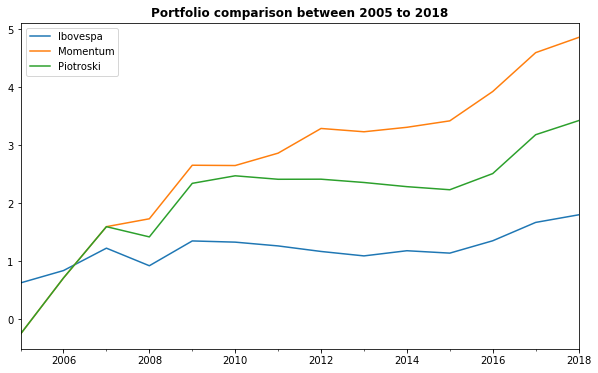

In [71]:
x = portfolio_returns().cumsum()
x.plot(figsize=(10,6))
plt.title("Portfolio comparison between 2005 to 2018", weight='bold');
plt.show()

# Hypothesis Testing

In [66]:
ibov_mean = kpi_output._calc_annualized_return(df).loc['Ibovespa']
ibov_std = kpi_output._calc_annualized_std_dev(df).loc['Ibovespa']
mom_mean = kpi_output._calc_annualized_return(df).loc['Momentum']
mom_std = kpi_output._calc_annualized_std_dev(df).loc['Momentum']
piotroski_mean = kpi_output._calc_annualized_return(df).loc['Piotroski']
piotroski_std = kpi_output._calc_annualized_std_dev(df).loc['Piotroski']

In [68]:
portfolio_returns()

,Ibovespa,Momentum,Piotroski
2005-12-31,0.624658,-0.2567,-0.2567
2006-12-31,0.212893,0.9665,0.9665
2007-12-31,0.386306,0.8852,0.8852
2008-12-31,-0.303206,0.1360,-0.1765
2009-12-31,0.427997,0.9241,0.9241
2010-12-31,-0.020687,-0.0052,0.1301
2011-12-31,-0.065217,0.2137,-0.0599
2012-12-31,-0.095600,0.4259,0.0014
2013-12-31,-0.076605,-0.0569,-0.0569
2014-12-31,0.089139,0.0771,-0.0720


In [69]:
portfolio_returns().cumsum()

,Ibovespa,Momentum,Piotroski
2005-12-31,0.624658,-0.2567,-0.2567
2006-12-31,0.837551,0.7098,0.7098
2007-12-31,1.223857,1.5950,1.5950
2008-12-31,0.920651,1.7310,1.4185
2009-12-31,1.348648,2.6551,2.3426
2010-12-31,1.327961,2.6499,2.4727
2011-12-31,1.262744,2.8636,2.4128
2012-12-31,1.167144,3.2895,2.4142
2013-12-31,1.090539,3.2326,2.3573
2014-12-31,1.179678,3.3097,2.2853


In [77]:
ib = portfolio_returns()
#ib['Ibovespa']
#ib['Momentum']
#ib[['Piotroski']]

In [78]:
# rates is a Normal random variable and has size equal to number of years
def portfolio_return(yrs, avg_return, sd_return, principal):
    np.random.seed(123)
    rates = np.random.normal(loc=avg_return, scale=sd_return, size=yrs)
    # Calculate the return at the end of the period
    end_return = principal
    for x in rates:
        end_return = end_return*(1+x)
    return end_return

result = portfolio_return(yrs = 14, avg_return = 0.3471, sd_return = 0.3915, principal = 10000)
print "Portfolio return after 14 years = {}".format(result)

Portfolio return after 14 years = 103107.377495


In [79]:
ibov_mean = kpi_output._calc_annualized_return(df).loc['Ibovespa']
ibov_std = kpi_output._calc_annualized_std_dev(df).loc['Ibovespa']
mom_mean = kpi_output._calc_annualized_return(df).loc['Momentum']
mom_std = kpi_output._calc_annualized_std_dev(df).loc['Momentum']
piotroski_mean = kpi_output._calc_annualized_return(df).loc['Piotroski']
piotroski_std = kpi_output._calc_annualized_std_dev(df).loc['Piotroski']

rets_momentum = []
rets_ibov = []
rets_piotroski = []
sims = 1000
for i in range(sims):
    rets_piotroski.append(portfolio_return(yrs = 14, avg_return = piotroski_mean, sd_return = piotroski_std, principal = 10000))
    rets_momentum.append(portfolio_return(yrs = 14, avg_return = mom_mean, sd_return = mom_std, principal = 10000))
    rets_ibov.append(portfolio_return(yrs = 14, avg_return = ibov_mean, sd_return = ibov_std, principal = 10000))

# Calculate the 25th percentile of the distributions and the amount you'd lose or gain
rets_piotroski_perc = np.percentile(rets_piotroski, 25)
rets_momentum_perc = np.percentile(rets_momentum, 25)
rets_ibov_perc = np.percentile(rets_ibov, 25)
additional_returns_piotroski = rets_piotroski_perc - rets_ibov_perc
additional_returns_momentum = rets_momentum_perc - rets_ibov_perc
print "Sticking to Piotroski instead of the buy and hold strategy gets you a loss of {}".format(additional_returns_piotroski)
print "Sticking to Momentum instead of the buy and hold strategy gets you an additional return of {}".format(additional_returns_momentum)

Sticking to Piotroski instead of the buy and hold strategy gets you a loss of -3829.7775825
Sticking to Momentum instead of the buy and hold strategy gets you an additional return of 85842.6014977


In [198]:
y2004 = portfolio_statistcs(2005, 'piotroski')[0]['Portfolio']
y2005 = portfolio_statistcs(2006, 'piotroski')[0]['Portfolio']
y2006 = portfolio_statistcs(2007, 'piotroski')[0]['Portfolio']
y2007 = portfolio_statistcs(2008, 'piotroski')[0]['Portfolio']
y2008 = portfolio_statistcs(2009, 'piotroski')[0]['Portfolio']
y2009 = portfolio_statistcs(2010, 'piotroski')[0]['Portfolio']
y2010 = portfolio_statistcs(2011, 'piotroski')[0]['Portfolio']
y2011 = portfolio_statistcs(2012, 'piotroski')[0]['Portfolio']
y2012 = portfolio_statistcs(2013, 'piotroski')[0]['Portfolio']
y2013 = portfolio_statistcs(2014, 'piotroski')[0]['Portfolio']
y2014 = portfolio_statistcs(2015, 'piotroski')[0]['Portfolio']
y2015 = portfolio_statistcs(2016, 'piotroski')[0]['Portfolio']
y2016 = portfolio_statistcs(2017, 'piotroski')[0]['Portfolio']
y2017 = portfolio_statistcs(2018, 'piotroski')[0]['Portfolio']
teste = pd.concat([y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,y2017])
teste.tail()

Date
2018-09-30   -0.020543
2018-10-31    0.161189
2018-11-30    0.042490
2018-12-31    0.230064
2019-01-31    0.086590
Name: Portfolio, dtype: float64

In [205]:
def monthly_returns():
    for i in range(2006,2018):
        x = portfolio_statistcs(i, 'piotroski')[0]['Portfolio']
        teste = pd.concat([x])
    return teste

In [206]:
monthly_returns()

Date
2017-05-31    0.088616
2017-06-30    0.117296
2017-07-31    0.034119
2017-08-31    0.080865
2017-09-30    0.075180
2017-10-31   -0.032559
2017-11-30   -0.009460
2017-12-31   -0.015805
2018-01-31    0.252953
2018-02-28   -0.021336
2018-03-31    0.010927
2018-04-30    0.003517
Name: Portfolio, dtype: float64

In [81]:
portfolio_statistcs(2018, 'piotroski')[0]

,CEDO4,CLSC4,CMIG4,CTNM4,BPAN4,GSHP3,Portfolio,Portfolio_Sum,Cumulative_Return
Date,,,,,,,,,
2018-05-31,-0.078508,0.051392,-0.036397,-0.269788,-0.026316,-0.221106,-0.096787,0.903213,0.903213
2018-06-30,-0.062833,-0.077371,-0.048240,-0.100763,-0.081081,-0.172043,-0.090389,0.909611,0.821573
2018-07-31,-0.042045,0.035088,0.127397,0.069610,0.005882,-0.002597,0.032222,1.032222,0.848046
2018-08-31,-0.052195,0.027119,-0.093560,-0.109524,-0.029240,-0.049479,-0.051146,0.948854,0.804671
2018-09-30,-0.013767,0.032673,-0.040214,-0.042781,-0.018072,-0.041096,-0.020543,0.979457,0.788141
2018-10-31,-0.175127,0.278364,0.540503,0.247672,0.104294,-0.028571,0.161189,1.161189,0.915181
2018-11-30,0.030769,0.035250,0.152312,0.044776,0.088889,-0.097059,0.042490,1.042490,0.954066
2018-12-31,-0.104478,0.204298,0.102345,0.040000,-0.005102,1.143322,0.230064,1.230064,1.173563
2019-01-31,0.050000,0.102867,-0.000722,0.440934,0.117949,-0.191489,0.086590,1.086590,1.275182


In [82]:
portfolio_statistcs(2018, 'momentum')[0]

,CEDO4,CLSC4,CMIG4,CTNM4,GSHP3,Portfolio,Portfolio_Sum,Cumulative_Return
Date,,,,,,,,
2018-05-31,-0.078508,0.051392,-0.036397,-0.269788,-0.221106,-0.110881,0.889119,0.889119
2018-06-30,-0.062833,-0.077371,-0.048240,-0.100763,-0.172043,-0.092250,0.907750,0.807097
2018-07-31,-0.042045,0.035088,0.127397,0.069610,-0.002597,0.037490,1.037490,0.837356
2018-08-31,-0.052195,0.027119,-0.093560,-0.109524,-0.049479,-0.055528,0.944472,0.790859
2018-09-30,-0.013767,0.032673,-0.040214,-0.042781,-0.041096,-0.021037,0.978963,0.774222
2018-10-31,-0.175127,0.278364,0.540503,0.247672,-0.028571,0.172568,1.172568,0.907828
2018-11-30,0.030769,0.035250,0.152312,0.044776,-0.097059,0.033210,1.033210,0.937976
2018-12-31,-0.104478,0.204298,0.102345,0.040000,1.143322,0.277098,1.277098,1.197888
2019-01-31,0.050000,0.102867,-0.000722,0.440934,-0.191489,0.080318,1.080318,1.294100
